# Import package


In [ ]:
import os
import requests
import autograd.numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from autograd import grad, jacobian, hessian
from scipy.optimize import minimize, Bounds
import datetime
from typing import List
from numba import njit
import warnings
import numpy.linalg as la
import time
from scipy.optimize import OptimizeResult
from manual_grad.basic_function import loss_function_component, discount_factor

# Data import and processing


## Online

In [81]:
settledate = pd.to_datetime(datetime.date.today())
bonds = pd.DataFrame(
    json.loads(
        requests.get(
            "https://asx.api.markitdigital.com/asx-research/1.0/bonds/government/exchange-traded?height=179&width=690"
        ).content
    )["data"]["items"]
)
bonds["maturity"] = bonds["securityDescription"].str.extract(r"(\d{2}-\d{2}-\d{2})")[0]
bonds["maturity"] = pd.to_datetime(bonds["maturity"], format="%d-%m-%y")
bonds = bonds[["maturity", "couponPercent", "priceBid", "priceAsk"]]
bonds["couponPercent"] = bonds["couponPercent"].astype(float) / 100
bonds.dropna(inplace=True)
bonds.sort_values("maturity", inplace=True)
bonds.reset_index(drop=True, inplace=True)
bonds.to_csv(f"data/bonds_{settledate.strftime('%Y%m%d')}.csv", index=False)
bonds

,maturity,couponPercent,priceBid,priceAsk
0,2025-11-21,0.0025,98.320,98.390
1,2026-04-21,0.0425,101.000,101.262
2,2026-09-21,0.0050,96.206,96.506
3,2027-04-21,0.0475,102.840,103.060
4,2027-11-21,0.0275,98.410,98.540
5,2028-05-21,0.0225,96.600,96.750
6,2028-11-21,0.0275,97.505,97.680
7,2029-04-21,0.0325,99.149,99.270
8,2029-11-21,0.0275,96.330,96.450
9,2030-05-21,0.0250,94.402,94.902


## Offline

In [82]:
settledate = pd.to_datetime("2025-05-18")
bonds = pd.read_csv(f"data/bonds_{settledate.strftime('%Y%m%d')}.csv")
bonds["maturity"] = pd.to_datetime(bonds["maturity"])
bonds

,maturity,couponPercent,priceBid,priceAsk
0,2025-11-21,0.0025,98.00,99.95
1,2026-04-21,0.0425,100.81,103.00
2,2027-04-21,0.0475,102.10,103.32
3,2027-11-21,0.0275,97.50,98.22
4,2028-05-21,0.0225,96.00,96.37
5,2029-04-21,0.0325,97.00,99.82
6,2033-04-21,0.0450,101.65,103.50
7,2034-12-21,0.0350,92.70,96.83
8,2037-04-21,0.0375,93.00,93.30
9,2039-06-21,0.0325,85.75,92.00


# Support function


In [83]:
def year_transform(date: pd.Timestamp) -> float:
    """Transform date to actual year"""
    if date == settledate:
        return 0
    years = date.year - settledate.year
    check_date = pd.Timestamp(
        year=date.year,
        month=settledate.month,
        day=settledate.day,
    )
    years += (date - check_date).days / abs(
        (
            check_date
            + pd.DateOffset(years=np.sign((date - check_date).days))
            - check_date
        ).days
    )
    return years


def coupon_date_generate(maturity: pd.Timestamp) -> np.ndarray:
    """Generate coupon dates"""
    coupon_dates = [maturity]
    while maturity - pd.DateOffset(months=6) > settledate:
        maturity -= pd.DateOffset(months=6)
        coupon_dates.append(maturity)
    return np.array(list(map(year_transform, coupon_dates[::-1])))


def result_to_df(
    res: OptimizeResult, param_names: list[str] = None, df: pd.DataFrame = None
) -> pd.DataFrame:
    """
    Convert a scipy OptimizeResult into a pandas DataFrame row, appending to an existing df if provided.

    Parameters
    ----------
    res : OptimizeResult
        The result object returned by scipy.optimize.minimize (or similar).
    param_names : list of str, optional
        Names for the elements of res.x. If None, defaults to ['x0','x1',...].
    df : pandas.DataFrame, optional
        Existing DataFrame to which the new row will be appended. If None, a new DataFrame is created.

    Returns
    -------
    df_out : pandas.DataFrame
        DataFrame with the new result row added at the end.
    """
    # Ensure res.x is array
    x = np.atleast_1d(res.x)
    n = x.shape[0]
    # Determine param names
    if param_names is None:
        param_names = [f"f{i}" for i in range(n)]
        param_names[n - 1] = "gamma"
    elif len(param_names) != n:
        raise ValueError(f"param_names length {len(param_names)} != len(res.x) {n}")
    # Build row dict
    row = {name: float(val) for name, val in zip(param_names, x)}
    # Standard OptimizeResult attributes
    for attr in ("fun", "nit", "nfev", "njev", "status"):  # numeric
        if hasattr(res, attr):
            row[attr] = getattr(res, attr)
    for attr in ("success", "message"):  # boolean or text
        if hasattr(res, attr):
            row[attr] = getattr(res, attr)
    # Create or append to DataFrame
    row_df = pd.DataFrame([row])
    if df is None:
        return row_df
    else:
        # preserve column order: union of existing and new
        return pd.concat([df, row_df], ignore_index=True)

# Discount factor curve


In [84]:
def plot(params: np.ndarray, func: callable) -> None:
    t = np.linspace(0, 30, 100000)
    dfs = func(params, t)
    plt.figure(figsize=(15, 6))
    plt.plot(t, dfs)
    plt.title("Discount Factor Curve")
    plt.xlabel("Years")
    plt.ylabel("Discount Factor")
    plt.grid()
    plt.show()

# Optimizing function


In [92]:
def constrained_target(params: np.ndarray) -> float:
    """Target function to be minimized"""
    return np.sum(
        [
            loss_function_component(
                params,
                coupon_date_generate(row["maturity"]),
                row["couponPercent"],
                row["priceBid"],
                row["priceAsk"],
            )
            for _, row in bonds.iterrows()
        ]
    )

In [93]:
def unconstrained_target(params: np.ndarray) -> float:
    """Target function to be minimized"""
    return np.sum(
        [
            loss_function_component(
                np.array([params[0], params[1], params[2], np.exp(params[3])]),
                coupon_date_generate(row["maturity"]),
                row["couponPercent"],
                row["priceBid"],
                row["priceAsk"],
            )
            for _, row in bonds.iterrows()
        ]
    )

## Library method for components


In [ ]:
from autograd import grad, jacobian

jac_library = grad(constrained_target)
hess_library = jacobian(grad(constrained_target))

## Analytical method for components


In [ ]:
from manual_grad.analytical_grad import loss_function_component_gradient_analytical
from manual_grad.analytical_grad import loss_function_component_hessian_analytical
import numpy as onp

def jac_analytical(params: np.ndarray) -> np.ndarray:
    """Calculate jacobian using analytical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_gradient_analytical(
                        onp.array(params),
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        element,
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
        ]
    )


def hess_analytical(params: np.ndarray) -> np.ndarray:
    """Calculate hessian using analytical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_hessian_analytical(
                        onp.array(params),
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        [element, element2],
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
            for element2 in range(len(params))
        ]
    ).reshape(len(params), len(params))

## Numerical method for components


In [ ]:
from manual_grad.numerical_grad import loss_function_component_gradient_numerical
from manual_grad.numerical_grad import loss_function_component_hessian_numerical
import numpy as onp

def jac_numerical(params: np.ndarray, tolerance: float = 1e-5) -> np.ndarray:
    """Calculate jacobian using numerical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_gradient_numerical(
                        onp.array(params),
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        element,
                        tolerance=tolerance,
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
        ]
    )


def hess_numerical(params: np.ndarray, tolerance: float = 1e-4) -> np.ndarray:
    """Calculate hessian using numerical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_hessian_numerical(
                        onp.array(params),
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        [element, element2],
                        tolerance=tolerance,
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
            for element2 in range(len(params))
        ]
    ).reshape(len(params), len(params))

# Comparing methods

# Scipy Benchmarking 
- Numpy has to be used for SciPy’s optimizers, imported as onp to avoid confusion

### Helper functions

In [ ]:
from scipy.optimize import OptimizeResult

def result_to_df(res: OptimizeResult, param_names: list[str] = None, df: pd.DataFrame = None, type: str = "con") -> pd.DataFrame:
    """
    Convert a scipy OptimizeResult into a pandas DataFrame row, appending to an existing df if provided.

    Parameters
    ----------
    res : OptimizeResult
        The result object returned by scipy.optimize.minimize (or similar).
    param_names : list of str, optional
        Names for the elements of res.x. If None, defaults to ['x0','x1',...].
    df : pandas.DataFrame, optional
        Existing DataFrame to which the new row will be appended. If None, a new DataFrame is created.

    Returns
    -------
    df_out : pandas.DataFrame
        DataFrame with the new result row added at the end.
    """
    # Ensure res.x is array
    x = np.atleast_1d(res.x)
    n = x.shape[0]
    # Determine param names
    if param_names is None:
        param_names = [f"f{i}" for i in range(n)]
        param_names[n-1] = "gamma"
    elif len(param_names) != n:
        raise ValueError(f"param_names length {len(param_names)} != len(res.x) {n}")
    # Build row dict
    row = {name: float(val) for name, val in zip(param_names, x)}
    row["x"] = x[3]
    row["gamma"] = np.exp(x[3]) if type == "uncon" else x[3]
    # Standard OptimizeResult attributes
    for attr in ("fun", "nit", "nfev", "njev", "status"):  # numeric
        if hasattr(res, attr):
            row[attr] = getattr(res, attr)
    for attr in ("success", "message"):  # boolean or text
        if hasattr(res, attr):
            row[attr] = getattr(res, attr)
    # Create or append to DataFrame
    row_df = pd.DataFrame([row])
    if df is None:
        return row_df
    else:
        # preserve column order: union of existing and new
        return pd.concat([df, row_df], ignore_index=True)

# Example usage:
# df = None
# df = result_to_df(res_pr, param_names=['beta0','beta1','beta2','eta'], df=df)
# df = result_to_df(res_bfgs, param_names=['beta0','beta1','beta2','eta'], df=df)
# df['gamma'] = np.exp(df['eta'])
# print(df)
# df_pr = result_to_df(res_pr, param_names=['beta0','beta1','beta2','eta'])
# df_pr['gamma'] = np.exp(df_pr['eta'])
# print(df_pr)

In [ ]:
# recover the true gamma
def true_gamma(res):
    beta0, beta1, beta2, eta_opt = res.x
    gamma_opt = np.exp(eta_opt)
    print("Optimized NS params:", [beta0, beta1, beta2, gamma_opt])
    print("Final loss:", res.fun)

### Data Setup

In [ ]:
import numpy as onp 

# AUTOGRAD grad / hessian
grad_ag = grad(constrained_target) 
hess_ag = hessian(constrained_target)

# Convert AUTOGRAD -> numpy
fun   = lambda x: float( constrained_target(np.array(x)) )
jac   = lambda x: onp.array( grad(constrained_target)(np.array(x)) )
hess  = lambda x: onp.array( hessian(constrained_target)(np.array(x)) )
hessp = lambda x,p: onp.array( hessian(constrained_target)(np.array(x)).dot(p) )

# shared x0 + bounds
x0   = onp.array([5, -1, 1, 1.5]) # FOR BOTH CONSTRAINED & UNCON? 5,-1,1,1.5
bnds = [(-onp.inf, onp.inf)]*3 + [(0, onp.inf)]
bobj = Bounds(*zip(*bnds))

In [ ]:
# make autodiff versions
grad_uncon = grad(unconstrained_target)

# boundary lambdas that convert ArrayBox → float / ndarray
fun_uncon = lambda y: float( unconstrained_target(np.array(y)) )
jac_uncon = lambda y: onp.array( grad_uncon(np.array(y)) )

# initial guess + (no bounds on y, since gamma = exp(eta) is always >0)
y0 = onp.array([5, -1, 1, onp.log(1.5)]) # FOR UNCONSTRAINED

# Prepare a container for histories
histories = {}

### Conjugate Gradient (CG, Polak–Ribiere: variety of Fletcher–Reeves)

In [ ]:
losses_cg = []
times_cg = []
t0 = time.perf_counter()


def cb_cg(xk):
    # xk is the current iterate
    losses_cg.append(unconstrained_target(xk))
    times_cg.append(time.perf_counter() - t0)


# CG (Polak–Ribière nonlinear conjugate‐gradient algorithm (with occasional restarts))
res_pr = minimize(
    fun_uncon,
    y0,
    jac=grad_uncon,
    method="CG",
    callback=cb_cg,
    options={"gtol": 1e-6, "maxiter": 300},
)
histories["CG"] = {"loss": losses_cg, "time": times_cg}
res_pr

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 3.1819802353405045e-05
       x: [ 1.397e+00 -1.358e+00 -5.171e-01  6.755e+00]
     nit: 159
     jac: [ 1.384e-07 -3.704e-07 -7.296e-07 -6.521e-07]
    nfev: 533
    njev: 511

In [ ]:
print(true_gamma(res_pr))

Optimized NS params: [1.396525577570328, -1.3575416279316288, -0.5171001682850043, 858.7164618183195]
Final loss: 3.1819802353405045e-05
None


In [ ]:
performances = result_to_df(res_pr, type="uncon")
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message
0,1.396526,-1.357542,-0.5171,858.716462,6.755439,0.000032,159,533,511,0,True,Optimization terminated successfully.


### Newton-CG & Trust-Region Newton

In [ ]:
losses_ncg = []
times_ncg  = []
t0 = time.perf_counter()
def cb_ncg(xk):
    losses_ncg.append(fun_uncon(xk))
    times_ncg .append(time.perf_counter() - t0)

res_newton = minimize(
    fun=fun_uncon,
    x0=y0,
    jac=jac_uncon,
    hessp=hessp,
    method='Newton-CG',
    callback=cb_ncg,
    options={'xtol':1e-8, 'maxiter':300}
)

histories["Newton-CG"] = {"loss": losses_ncg, "time": times_ncg}

In [ ]:
print("Newton-CG →", res_newton.x, res_newton.fun)
print(true_gamma(res_newton))
res_newton

Newton-CG → [ 1.61017635 -1.59058531 -1.11596579  5.0480632 ] 0.03142466500400878
Optimized NS params: [1.6101763494800436, -1.590585305840031, -1.1159657865501387, 155.72057337845143]
Final loss: 0.03142466500400878
None


 message: Warning: Maximum number of iterations has been exceeded.
 success: False
  status: 1
     fun: 0.03142466500400878
       x: [ 1.610e+00 -1.591e+00 -1.116e+00  5.048e+00]
     nit: 300
     jac: [-5.022e-02 -2.218e-01  1.594e-01 -1.015e-01]
    nfev: 348
    njev: 348
    nhev: 339

In [ ]:
performances = result_to_df(res_newton, df=performances, type="uncon")
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message
0,1.396526,-1.357542,-0.517100,858.716462,6.755439,0.000032,159,533,511,0,True,Optimization terminated successfully.
1,1.610176,-1.590585,-1.115966,155.720573,5.048063,0.031425,300,348,348,1,False,Warning: Maximum number of iterations has been...


### L-BFGS-B

In [ ]:
losses_lbfgsb = []
times_lbfgsb  = []
t0 = time.perf_counter()
def cb_lbfgsb(xk):
    losses_lbfgsb.append(fun_uncon(xk))
    times_lbfgsb.append(time.perf_counter() - t0)

res_L_BFGS_B = minimize(
    fun=fun,
    x0=x0,
    jac=jac,
    bounds=bnds,
    method='L-BFGS-B',
    callback=cb_lbfgsb,
    options={'ftol':1e-9, 'maxiter':300}
)
histories["L-BFGS-B"] = {"loss": losses_lbfgsb, "time": times_lbfgsb}
res_L_BFGS_B 

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.3492190492169155e-05
        x: [ 6.142e-02 -2.404e-02 -1.219e-02  8.086e+00]
      nit: 32
      jac: [ 1.171e-04  1.330e-05  9.844e-06 -2.814e-07]
     nfev: 60
     njev: 60
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [ ]:
performances = result_to_df(res_L_BFGS_B, df=performances)
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message
0,1.396526,-1.357542,-0.517100,858.716462,6.755439,0.000032,159,533,511,0,True,Optimization terminated successfully.
1,1.610176,-1.590585,-1.115966,155.720573,5.048063,0.031425,300,348,348,1,False,Warning: Maximum number of iterations has been...
2,0.061423,-0.024040,-0.012191,8.086305,8.086305,0.000013,32,60,60,0,True,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


### BFGS

In [ ]:
losses_bfgs = []
times_bfgs  = []
t0 = time.perf_counter()
def cb_bfgs(y):
    losses_bfgs.append(fun_uncon(y))
    times_bfgs.append(time.perf_counter() - t0)

res_bfgs = minimize(
    fun=fun_uncon,
    x0=y0,
    jac=jac_uncon,
    method='BFGS',
    callback=cb_bfgs,
    options={'gtol':1e-6, 'maxiter':300}
)
histories["BFGS"] = {"loss": losses_bfgs, "time": times_bfgs}
res_bfgs

/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 6.5216008065555755
        x: [ 2.197e+00 -3.339e+00  5.980e-01  1.100e+00]
      nit: 1
      jac: [ 1.941e-01 -6.417e-01  4.914e-01 -1.637e+00]
 hess_inv: [[ 1.223e+02  9.672e+01  1.998e+01 -3.894e+01]
            [ 9.672e+01  7.797e+01  1.603e+01 -3.139e+01]
            [ 1.998e+01  1.603e+01  4.238e+00 -6.228e+00]
            [-3.894e+01 -3.139e+01 -6.228e+00  1.286e+01]]
     nfev: 24
     njev: 12

In [ ]:
if res_bfgs.success:
    print(true_gamma(res_bfgs))
res_bfgs

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 6.5216008065555755
        x: [ 2.197e+00 -3.339e+00  5.980e-01  1.100e+00]
      nit: 1
      jac: [ 1.941e-01 -6.417e-01  4.914e-01 -1.637e+00]
 hess_inv: [[ 1.223e+02  9.672e+01  1.998e+01 -3.894e+01]
            [ 9.672e+01  7.797e+01  1.603e+01 -3.139e+01]
            [ 1.998e+01  1.603e+01  4.238e+00 -6.228e+00]
            [-3.894e+01 -3.139e+01 -6.228e+00  1.286e+01]]
     nfev: 24
     njev: 12

In [ ]:
performances = result_to_df(res_bfgs, df=performances, type="uncon")
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message
0,1.396526,-1.357542,-0.517100,858.716462,6.755439,0.000032,159,533,511,0,True,Optimization terminated successfully.
1,1.610176,-1.590585,-1.115966,155.720573,5.048063,0.031425,300,348,348,1,False,Warning: Maximum number of iterations has been...
2,0.061423,-0.024040,-0.012191,8.086305,8.086305,0.000013,32,60,60,0,True,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
3,2.197378,-3.338956,0.598015,3.005209,1.100347,6.521601,1,24,12,2,False,Desired error not necessarily achieved due to ...


### SLSQP (General Constrained NLP)

In [ ]:
losses_slsqp = []
times_slsqp  = []
t0 = time.perf_counter()
def cb_slsqp(xk):
    losses_slsqp.append(fun(xk))
    times_slsqp.append(time.perf_counter() - t0)

res_slsqp = minimize(
    fun=fun,
    x0=x0,
    jac=jac,
    bounds=bobj,
    method='SLSQP',
    callback=cb_slsqp,
    options={'ftol':1e-9, 'maxiter':300}
)
histories["SLSQP"] = {"loss": losses_slsqp, "time": times_slsqp}
res_slsqp

/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/s

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.4066222914813934e-05
       x: [ 5.940e-02 -2.186e-02 -1.456e-02  6.173e+00]
     nit: 35
     jac: [ 1.335e-04 -3.428e-05  2.789e-05 -7.379e-07]
    nfev: 72
    njev: 35

In [ ]:
performances = result_to_df(res_slsqp, df=performances)
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message
0,1.396526,-1.357542,-0.517100,858.716462,6.755439,0.000032,159,533,511,0,True,Optimization terminated successfully.
1,1.610176,-1.590585,-1.115966,155.720573,5.048063,0.031425,300,348,348,1,False,Warning: Maximum number of iterations has been...
2,0.061423,-0.024040,-0.012191,8.086305,8.086305,0.000013,32,60,60,0,True,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
3,2.197378,-3.338956,0.598015,3.005209,1.100347,6.521601,1,24,12,2,False,Desired error not necessarily achieved due to ...
4,0.059399,-0.021861,-0.014560,6.172718,6.172718,0.000014,35,72,35,0,True,Optimization terminated successfully


### Trust-constr (General Constrained NLP)

In [ ]:
losses_trust = []
times_trust  = []
t0 = time.perf_counter()
def cb_trust(xk, state):
    # trust-constr callback signature takes (xk, OptimizeResult)
    losses_trust.append(fun_uncon(xk))
    times_trust .append(time.perf_counter() - t0)

res_trust = minimize(
    fun=fun,
    x0=x0,
    jac=jac,
    hess=hess,
    bounds=bobj,
    method='trust-constr',
    callback=cb_trust,
    options={'gtol':1e-8, 'maxiter':300}
)
histories["Trust-constr"] = {"loss": losses_trust, "time": times_trust}
res_trust

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: 1.3146517703206194e-05
                 x: [ 6.595e-02 -2.867e-02 -4.190e-03  1.500e+01]
               nit: 272
              nfev: 229
              njev: 169
              nhev: 169
          cg_niter: 557
      cg_stop_cond: 4
              grad: [-2.275e-10  1.655e-10  3.853e-10 -6.621e-09]
   lagrangian_grad: [-2.275e-10  1.655e-10  3.853e-10 -7.271e-09]
            constr: [array([ 6.595e-02, -2.867e-02, -4.190e-03,  1.500e+01])]
               jac: [<4x4 sparse matrix of type '<class 'numpy.float64'>'
                    	with 4 stored elements in Compressed Sparse Row format>]
       constr_nfev: [0]
       constr_njev: [0]
       constr_nhev: [0]
                 v: [array([ 0.000e+00,  0.000e+00,  0.000e+00, -6.504e-10])]
            method: tr_interior_point
        optimality: 7.271315219308304e-09
  constr_violation: 0.0
    execution_time: 21.

In [ ]:
performances = result_to_df(res_trust, df=performances)
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message
0,1.396526,-1.357542,-0.517100,858.716462,6.755439,0.000032,159,533,511,0,True,Optimization terminated successfully.
1,1.610176,-1.590585,-1.115966,155.720573,5.048063,0.031425,300,348,348,1,False,Warning: Maximum number of iterations has been...
2,0.061423,-0.024040,-0.012191,8.086305,8.086305,0.000013,32,60,60,0,True,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
3,2.197378,-3.338956,0.598015,3.005209,1.100347,6.521601,1,24,12,2,False,Desired error not necessarily achieved due to ...
4,0.059399,-0.021861,-0.014560,6.172718,6.172718,0.000014,35,72,35,0,True,Optimization terminated successfully
5,0.065947,-0.028666,-0.004190,14.997719,14.997719,0.000013,272,229,169,1,True,`gtol` termination condition is satisfied.


### View results

In [ ]:
performances["algo"] = ["CG", "Newton-CG", "L-BFGS-B", "BFGS", "SLSQP", "Trust-constr"]
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message,algo
0,1.396526,-1.357542,-0.517100,858.716462,6.755439,0.000032,159,533,511,0,True,Optimization terminated successfully.,CG
1,1.610176,-1.590585,-1.115966,155.720573,5.048063,0.031425,300,348,348,1,False,Warning: Maximum number of iterations has been...,Newton-CG
2,0.061423,-0.024040,-0.012191,8.086305,8.086305,0.000013,32,60,60,0,True,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,L-BFGS-B
3,2.197378,-3.338956,0.598015,3.005209,1.100347,6.521601,1,24,12,2,False,Desired error not necessarily achieved due to ...,BFGS
4,0.059399,-0.021861,-0.014560,6.172718,6.172718,0.000014,35,72,35,0,True,Optimization terminated successfully,SLSQP
5,0.065947,-0.028666,-0.004190,14.997719,14.997719,0.000013,272,229,169,1,True,`gtol` termination condition is satisfied.,Trust-constr


### Plot target func value over iterations and time

99th percentile loss: 2053.7537308781434


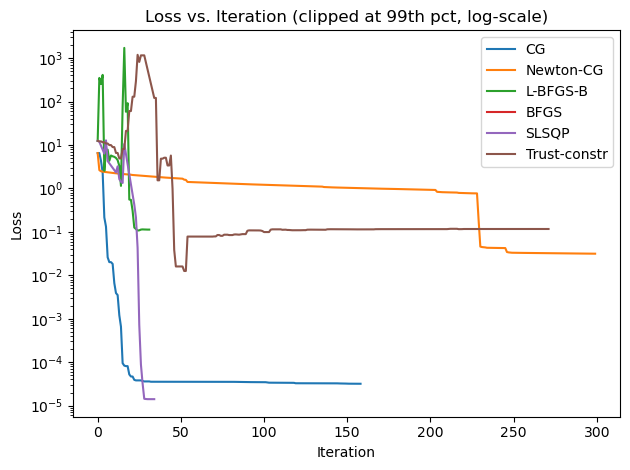

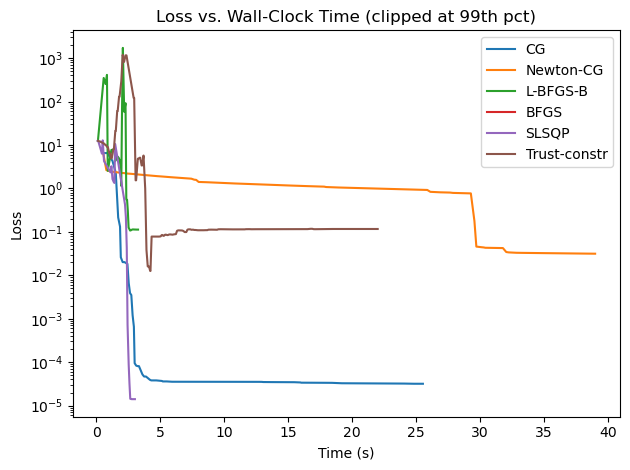

In [ ]:
# stack and filter finite losses
all_losses = onp.hstack([
    onp.array(h['loss'])[ onp.isfinite(h['loss']) ]
    for h in histories.values()
])

# high‐end cutoff (e.g. the 99th percentile)
cutoff = onp.percentile(all_losses, 99)
print("99th percentile loss:", cutoff)

plt.figure()
for name, h in histories.items():
    loss = onp.array(h['loss'])
    mask = onp.isfinite(loss) & (loss <= cutoff)
    plt.plot(onp.nonzero(mask)[0], loss[mask], label=name)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration (clipped at 99th pct, log-scale)')
plt.legend()
plt.tight_layout()
plt.savefig('loss_vs_iteration_clipped.pdf')
plt.show()

plt.figure()
for name, h in histories.items():
    loss = onp.array(h['loss'])
    time_steps = onp.array(h['time'])
    # same mask as before
    mask = onp.isfinite(loss) & (loss <= cutoff)
    # plot time_steps vs. loss
    plt.plot(time_steps[mask], loss[mask], label=name)
plt.xlabel('Time (s)')
plt.ylabel('Loss')
plt.title('Loss vs. Wall-Clock Time (clipped at 99th pct)')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('loss_vs_time_clipped.pdf')
plt.show()

### Export the run results into excel/csv

In [ ]:
format_x0(x0)

'(5-0_-1-0_1-0_1-5)'

In [ ]:
import os
import numpy as np
import pandas as pd

def format_x0(x0: np.ndarray) -> str:
    """
    Turn an array like [5, -1, 0.52, 1.5] into a string '(5_-1_0-52_1-5)'.
    """
    # flatten in case it's not 1-D
    flat = x0.flatten()
    parts = []
    print()
    for val in flat:
        # convert to Python number, then to string
        s = str(val)
        # replace decimal point with dash
        s = s.replace('.', '-')
        parts.append(s)
    return "(" + "_".join(parts) + ")"

def next_excel_filename(
    prefix: str,
    directory: str = '.',
    x0: np.ndarray = None
) -> str:
    """
    Find the next Excel filename for histories, e.g. 'histories_run_0001.xlsx'
    or, if x0 is provided:
      'histories_run_0001_(5_-1_0-52_1-5).xlsx'
    """
    existing = [
        f for f in os.listdir(directory)
        if f.startswith(f"{prefix}_run_") and f.endswith(".xlsx")
    ]
    idxs = []
    for f in existing:
        try:
            idx = int(f.split("_run_")[1].split(".xlsx")[0].split("(")[0])
            idxs.append(idx)
        except ValueError:
            continue
    next_idx = max(idxs) + 1 if idxs else 1

    fname = f"{prefix}_run_{next_idx:04d}"
    if x0 is not None:
        fname += format_x0(x0)
    return fname + ".xlsx"

# Generate the next Excel filename with x0 in it
hist_excel = next_excel_filename("histories", x0=x0)

# Write histories to Excel with each solver as a separate sheet
with pd.ExcelWriter(hist_excel, engine='xlsxwriter') as writer:
    for solver, data in histories.items():
        df = pd.DataFrame({
            'loss': data['loss'],
            'time': data['time']
        })
        sheet_name = solver[:31]  # stick to Excel's 31-char limit
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Saved history workbook to {hist_excel}")

# And similarly for performances (as CSV, if you like)
perf_filename = hist_excel.replace("histories", "performances").replace(".xlsx", ".csv")
performances.to_csv(perf_filename, index=False)
print(f"Saved performances to {perf_filename}")

Saved history workbook to histories_run_0002(5-0_-1-0_1-0_1-5).xlsx
Saved performances to performances_run_0002(5-0_-1-0_1-0_1-5).csv


# Hayoung!!!

In [ ]:
def is_positive_semidefinite(H: np.ndarray) -> bool:
    eigenvalues = np.linalg.eigvalsh(H) 
    return np.all(eigenvalues >= 0) 

param_grid = [
    [f0, f1, f2, gamma]
    for f0 in np.linspace(-5, 5, 10)
    for f1 in np.linspace(-5, 5, 10)
    for f2 in np.linspace(-5, 5, 10)
    for gamma in np.linspace(1, 20, 10)
]

for params in param_grid:
    H = hess_analytical(params) 
    if not is_positive_semidefinite(H):
        print("❌ Not PSD at:", params)

❌ Not PSD at: [np.float64(-5.0), np.float64(-5.0), np.float64(-5.0), np.float64(1.0)]
❌ Not PSD at: [np.float64(-5.0), np.float64(-5.0), np.float64(-5.0), np.float64(3.111111111111111)]
❌ Not PSD at: [np.float64(-5.0), np.float64(-5.0), np.float64(-5.0), np.float64(5.222222222222222)]
❌ Not PSD at: [np.float64(-5.0), np.float64(-5.0), np.float64(-5.0), np.float64(7.333333333333334)]
❌ Not PSD at: [np.float64(-5.0), np.float64(-5.0), np.float64(-5.0), np.float64(9.444444444444445)]
❌ Not PSD at: [np.float64(-5.0), np.float64(-5.0), np.float64(-5.0), np.float64(11.555555555555555)]
❌ Not PSD at: [np.float64(-5.0), np.float64(-5.0), np.float64(-5.0), np.float64(13.666666666666668)]
❌ Not PSD at: [np.float64(-5.0), np.float64(-5.0), np.float64(-5.0), np.float64(15.777777777777779)]
❌ Not PSD at: [np.float64(-5.0), np.float64(-5.0), np.float64(-5.0), np.float64(17.88888888888889)]
❌ Not PSD at: [np.float64(-5.0), np.float64(-5.0), np.float64(-5.0), np.float64(20.0)]
❌ Not PSD at: [np.float6

KeyboardInterrupt: 

In [ ]:
initial_params = np.array([100, 100, 100, 18])
target_grad = grad(target)

result = minimize(
    fun=target,
    x0=initial_params,
    method="BFGS",          # Quasi-Newton
    jac=target_grad,       
    options={"disp": True}
)

Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 57
         Function evaluations: 117
         Gradient evaluations: 117


In [ ]:
print(result.success)
print(result.x)
print(result.fun)

True
[-15.54256384  15.5799408   16.42904169 551.54410188]
1.331778587054094e-05


In [ ]:
est_gamma = result.x[3]
est_f3 = result.x[2]
est_f3,est_gamma

(np.float64(7.640460074583044e-05), np.float64(17.873488302228893))

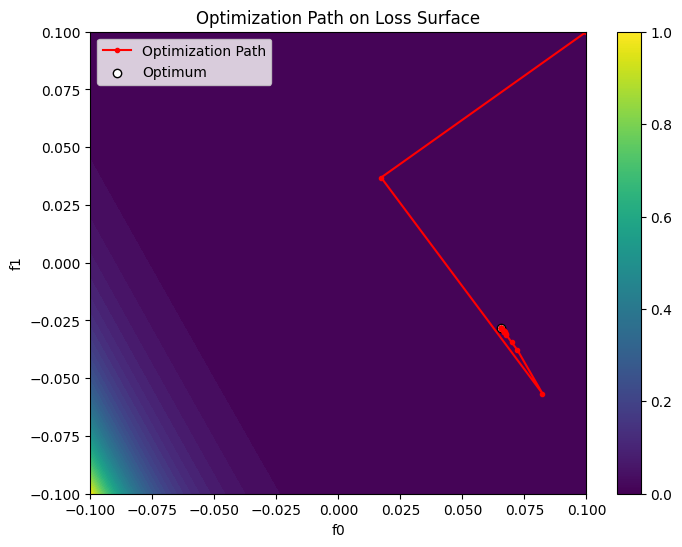

In [ ]:
import autograd.numpy as np
f2_fixed = 0
gamma_fixed = 17

# f0, f1 범위 좁게
f0_vals = np.linspace(-0.1, 0.1, 100)
f1_vals = np.linspace(-0.1, 0.1, 100)

F0, F1 = np.meshgrid(f0_vals, f1_vals)
Z = np.zeros_like(F0)

# 손실 계산
for i in range(F0.shape[0]):
    for j in range(F0.shape[1]):
        params = np.array([F0[i, j], F1[i, j], f2_fixed, gamma_fixed])
        Z[i, j] = target(params)
def wrapped(params_2d):
    f0, f1 = params_2d
    return target(np.array([f0, f1, f2_fixed, gamma_fixed]))

grad_func = grad(wrapped)
start = np.array([0.1, 0.1])
trace = [start.copy()]

def callback(xk):
    trace.append(xk.copy())

res = minimize(wrapped, start, method='BFGS', jac=grad_func, callback=callback)

# 2d plot
trace = np.array(trace)
plt.figure(figsize=(8, 6))
plt.contourf(F0, F1, Z, levels=50, cmap="viridis")
plt.plot(trace[:, 0], trace[:, 1], 'r.-', label='Optimization Path')
plt.scatter(res.x[0], res.x[1], color='white', edgecolor='black', label='Optimum')
plt.xlabel("f0")
plt.ylabel("f1")
plt.title("Optimization Path on Loss Surface")
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)
plt.legend()
plt.colorbar()
plt.show()

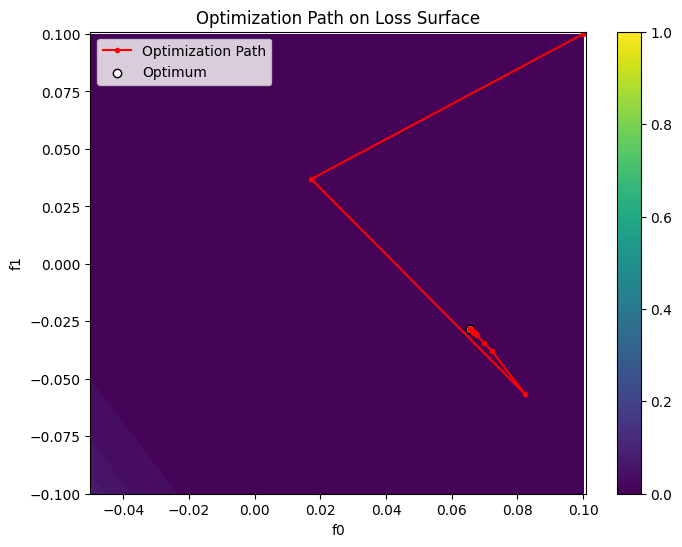

In [ ]:
trace = np.array(trace)
plt.figure(figsize=(8, 6))
plt.contourf(F0, F1, Z, levels=50, cmap="viridis")
plt.plot(trace[:, 0], trace[:, 1], 'r.-', label='Optimization Path')
plt.scatter(res.x[0], res.x[1], color='white', edgecolor='black', label='Optimum')
plt.xlabel("f0")
plt.ylabel("f1")
plt.title("Optimization Path on Loss Surface")
plt.xlim(-0.05, 0.101)
plt.ylim(-0.1, 0.101)
plt.legend()
plt.colorbar()
plt.show()

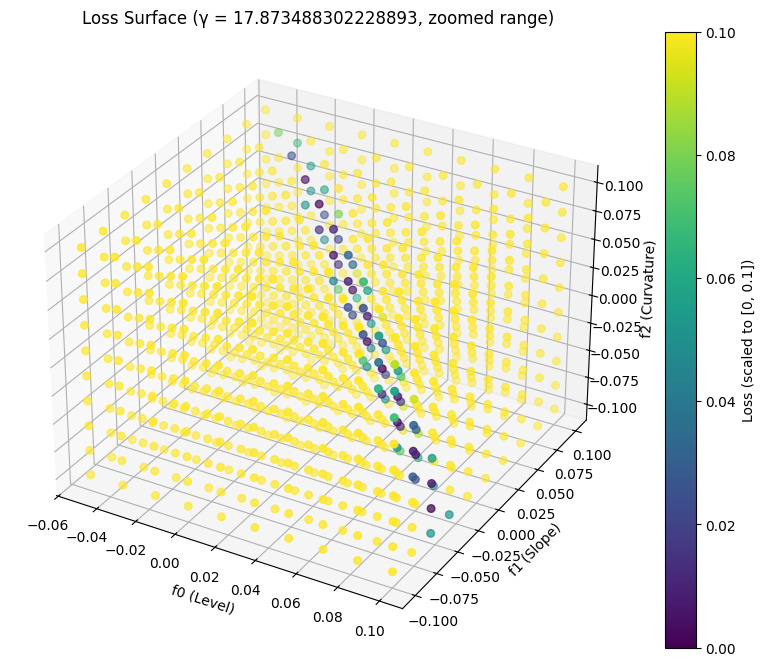

In [ ]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

gamma_fixed = est_gamma

f0_vals = np.linspace(-0.05, 0.1, 10)
f1_vals = np.linspace(-0.1, 0.1, 10)
f2_vals = np.linspace(-0.1, 0.1, 10)

f0_list = []
f1_list = []
f2_list = []
loss_list = []

for f0 in f0_vals:
    for f1 in f1_vals:
        for f2 in f2_vals:
            params = np.array([f0, f1, f2, gamma_fixed])
            loss = target(params)
            f0_list.append(f0)
            f1_list.append(f1)
            f2_list.append(f2)
            loss_list.append(loss)

f0_arr = np.array(f0_list)
f1_arr = np.array(f1_list)
f2_arr = np.array(f2_list)
loss_arr = np.array(loss_list)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    f0_arr, f1_arr, f2_arr,
    c=loss_arr,
    cmap='viridis',
    s=30,
    vmin=0.0,
    vmax=0.1
)

ax.set_xlabel("f0 (Level)")
ax.set_ylabel("f1 (Slope)")
ax.set_zlabel("f2 (Curvature)")
ax.set_title(f"Loss Surface (γ = {gamma_fixed}, zoomed range)")

cbar = plt.colorbar(sc, label="Loss")
cbar.ax.set_ylabel("Loss (scaled to [0, 0.1])")

plt.show()
